# Working with Domain-Specific Data

In this notebook we'll look at working with domain-specific unstructred data&mdash;images, text, etc.

In [1]:
%matplotlib inline

import math
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import (Bidirectional, Conv2D, Dense, Embedding, Flatten, GlobalAveragePooling1D,
                          Input, LSTM, MaxPooling2D, Reshape)
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from mlxtend.plotting import plot_confusion_matrix
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import (accuracy_score, auc, classification_report, confusion_matrix,
                             mean_squared_error, precision_recall_curve, roc_curve)
from sklearn.model_selection import KFold, learning_curve, ShuffleSplit, train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

#warnings.filterwarnings('ignore')

# Image Classification

## Load the MNIST Dataset

Dataset of 28x28 pixel images of handwritten digits. From https://www.kaggle.com/c/digit-recognizer.

In [2]:
df_img_train = pd.read_csv('../data/digit-recognizer/train.csv')
df_img_test = pd.read_csv('../data/digit-recognizer/test.csv')

In [3]:
df_img_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_img_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [5]:
sorted(df_img_train['label'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [6]:
df_img_train['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

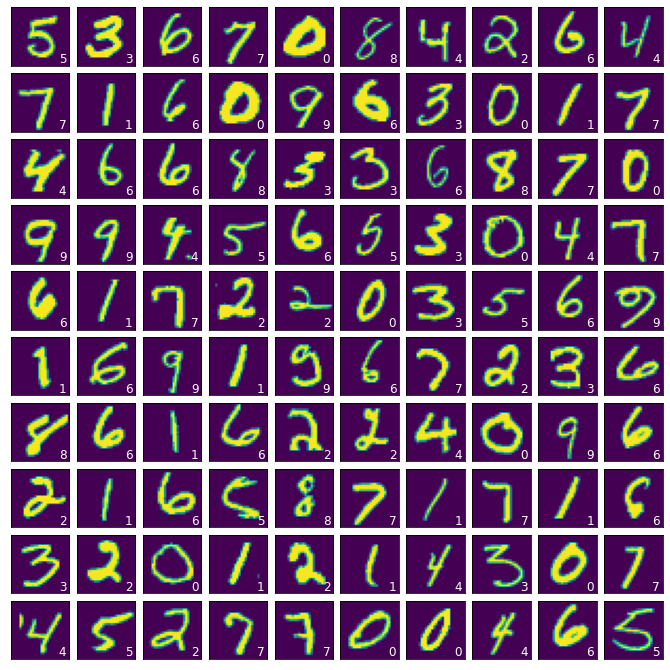

In [7]:
images, labels = zip(*[(df_img_train.iloc[i.astype(int), 1:].values.reshape(28, 28),
                        df_img_train.iloc[i.astype(int), 0])
                       for i in (np.random.rand(100) * len(df_img_train))])

fig = plt.figure(figsize=(12., 12.))
grid = ImageGrid(
    fig, 111,  # similar to subplot(111)
    nrows_ncols=(10, 10),  # creates 2x2 grid of axes
    axes_pad=0.1  # pad between axes in inches
)

for idx, (ax, im, lb) in enumerate(zip(grid, images, labels)):
    ax.imshow(im)
    ax.set_title(lb, fontdict=None, loc='right', y=-.05, x=.95, color='white')
    ax.tick_params(labelbottom=False)
    grid[idx].get_xaxis().set_ticks([])
    grid[idx].get_yaxis().set_ticks([])

## Data Preprocessing

To train a model, we must identify and extract feature columns. We must also extract the label column and convert it to categorical values.

In [8]:
X_img = df_img_train.iloc[:, 1:]
y_img = df_img_train['label']

In [9]:
y_img_cat = to_categorical(y_img)
y_img_cat

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

## Model Building

Build image classification models. Here we build two artificial neural networks. The neural network models can use the raw image pixels as input without any feature engineering.

We will start by building a simple, dense (fully connected) neural network (DNN).

In [10]:
inputs = Input(shape=(784,))
x = Dense(128, activation='relu')(inputs)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model_img_dnn = Model(inputs=inputs, outputs=outputs)
model_img_dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_img_dnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________


Next, we will build a convolutional neural network (CNN).

In [11]:
inputs = Input(shape=(784,))
x = Reshape((28, 28, 1))(inputs) # reshape to [height, width, depth]

x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model_img_cnn = Model(inputs=inputs, outputs=outputs)
model_img_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_img_cnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          1849

Notice that the CNN actually has fewer trainable parameters than the DNN.

## Model Training

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X_img, y_img_cat, test_size=0.2, random_state=0)

For the purpose of comparison, we can train some baseline models.

In [13]:
model_img_dummy = DummyClassifier(strategy='stratified')
model_img_dummy.fit(X_train, y_train);

model_img_per = MultiOutputRegressor(Perceptron())
model_img_per.fit(X_train, y_train);

Next we train the neural networks.

In [14]:
history_img_dnn = model_img_dnn.fit(X_train, y_train, epochs=10, verbose=0, validation_data=(X_valid, y_valid));

In [15]:
history_img_cnn = model_img_cnn.fit(X_train, y_train, epochs=10, verbose=0, validation_data=(X_valid, y_valid));

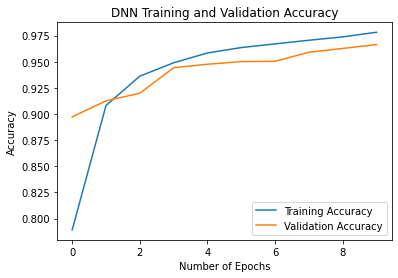

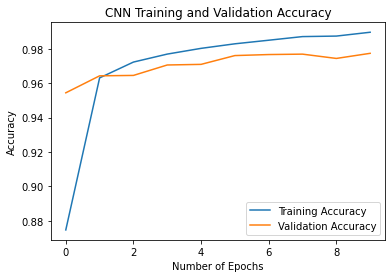

In [16]:
def plot_train_history(model_name, metric_name, var1, var2):
    metrics[[var1, var2]].plot()
    plt.title(f"{model_name} Training and Validation {metric_name}")
    plt.xlabel("Number of Epochs")
    plt.ylabel(metric_name)
    plt.legend([var1, var2])


for model_name, model_history in {'DNN': history_img_dnn, 'CNN': history_img_cnn}.items():
    metrics = pd.DataFrame(model_history.history)
    metrics = metrics.rename(columns={'loss': 'Training Loss', 'accuracy': 'Training Accuracy',
                                      'val_loss': 'Validation Loss', 'val_accuracy': 'Validation Accuracy'})
    #plot_train_history(model_name, 'Loss', 'Training Loss', 'Validation Loss')
    plot_train_history(model_name, 'Accuracy', 'Training Accuracy', 'Validation Accuracy')

## Model Evaluation

The models produce 10 outputs, one for each digit. Each output ranges from 0 to 1. We can consider the digit with the largest output value as the prediction.

In [17]:
# Helper function for breaking ties from DummyClassifier, which can produce multiple outputs.
def rand_argmax(a, **kwargs):
    """Argmax with random tiebreaks for 2d array."""
    y, x = np.where((a.T == a.max(1)).T)
    aux = np.random.permutation(len(y))
    xa = np.empty_like(x)
    xa[aux] = x
    return xa[np.maximum.reduceat(aux, np.where(np.diff(y, prepend=-1))[0])]

In [18]:
models = {
    'Dummy': model_img_dummy,
    'Perceptron': model_img_per,
    'DNN': model_img_dnn,
    'CNN': model_img_cnn
}

In [19]:
for model_name, model in models.items():
    y_true = rand_argmax(y_valid, axis=1)
    y_pred = rand_argmax(model.predict(X_valid), axis=1)
    print(model_name.ljust(16), accuracy_score(y_true, y_pred))

Dummy            0.0988095238095238
Perceptron       0.8011904761904762
DNN              0.9664285714285714
CNN              0.9773809523809524


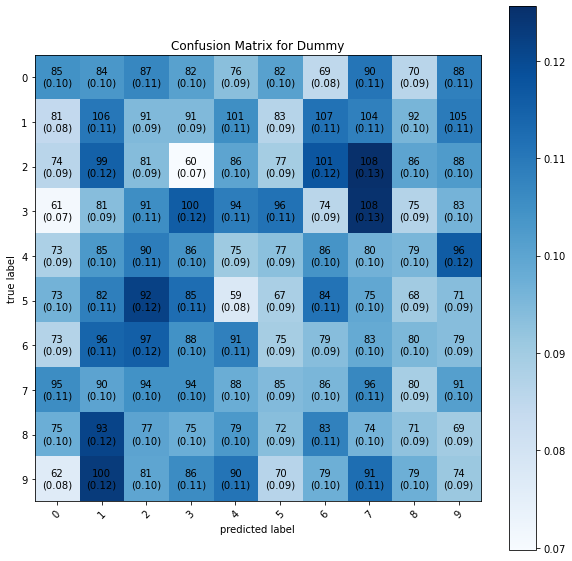

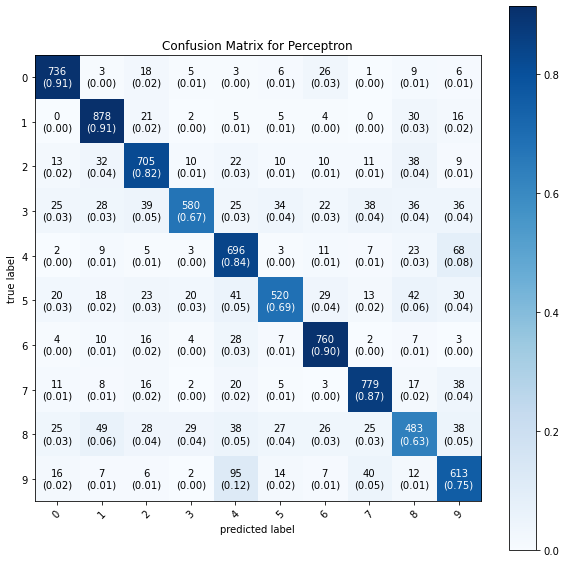

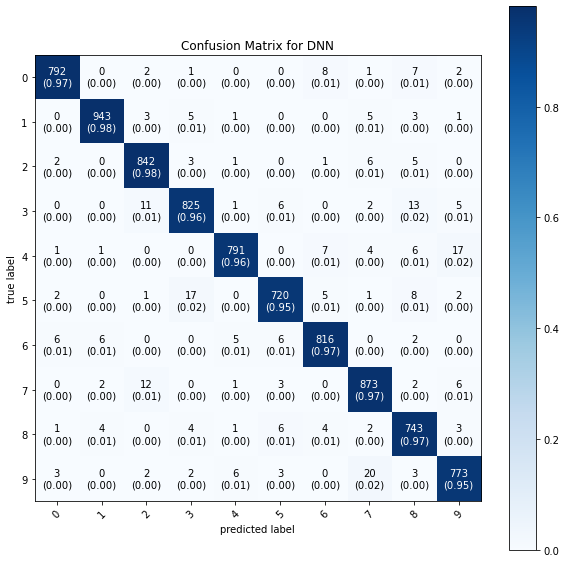

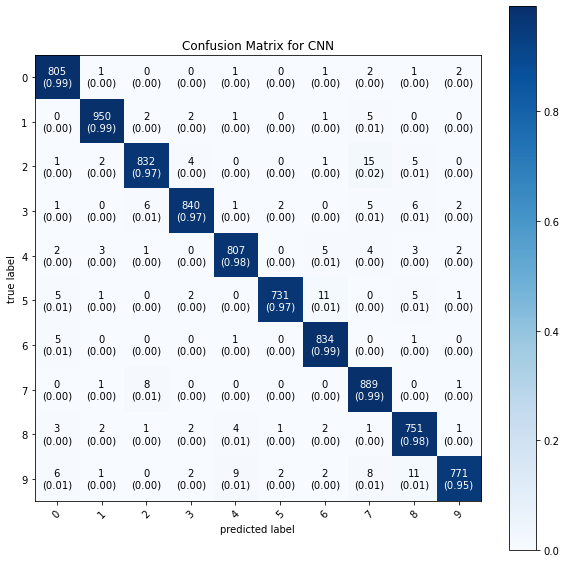

In [20]:
for model_name, model in models.items():
    y_pred = rand_argmax(model.predict(X_valid), axis=1)
    y_test = rand_argmax(y_valid, axis=1)

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(
        conf_mat=cm,
        figsize=(10, 10),
        colorbar=True,
        show_absolute=True,
        show_normed=True,
        class_names=np.arange(10)
    )
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

## Predict on New Data

For each test instance, predict the digit that has the highest prediction score.

In [21]:
for model_name, model in {'DNN': model_img_dnn, 'CNN': model_img_cnn}.items():
    print(f"{model_name} predictions:", np.argmax(model.predict(df_img_test), axis=1))

DNN predictions: [2 0 9 ... 3 9 2]
CNN predictions: [2 0 9 ... 3 9 2]


We can identify and visualize cases where the neural network models disagree.

In [22]:
y_pred_dnn = np.argmax(model_img_dnn.predict(df_img_test), axis=1)
y_pred_cnn = np.argmax(model_img_cnn.predict(df_img_test), axis=1)

In [23]:
disagree_idx = np.argwhere(y_pred_dnn != y_pred_cnn).squeeze()
len(disagree_idx)

1143

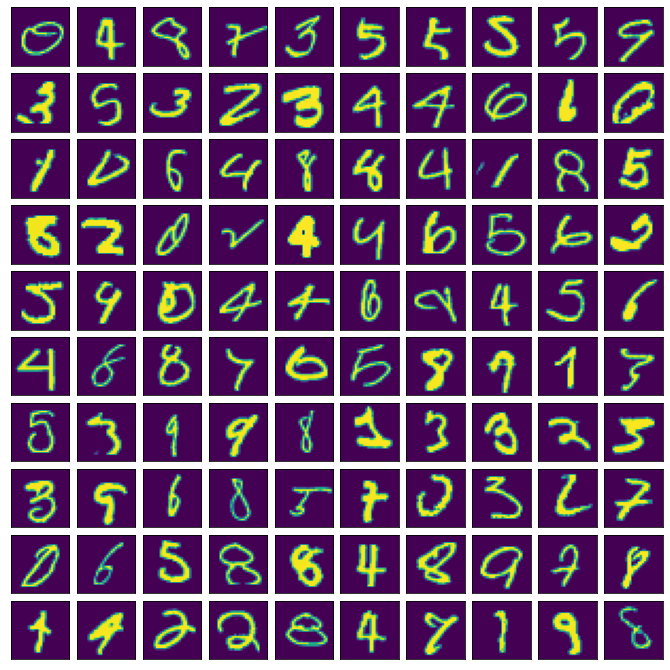

In [24]:
images = [df_img_test.iloc[i].values.reshape(28, 28) for i in disagree_idx[:100]]

fig = plt.figure(figsize=(12., 12.))
grid = ImageGrid(
    fig, 111,  # similar to subplot(111)
    nrows_ncols=(10, 10),  # creates 2x2 grid of axes
    axes_pad=0.1  # pad between axes in inches
)

for idx, (ax, im) in enumerate(zip(grid, images)):
    ax.imshow(im)
    grid[idx].get_xaxis().set_ticks([])
    grid[idx].get_yaxis().set_ticks([])

# Text Classification

## Load the SMS Spam Dataset

From https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection.

In [25]:
df_txt = pd.read_csv('../data/SMSSpamCollection', sep='\t', names=['class', 'text'])

In [26]:
df_txt.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [27]:
df_txt['text_length'] = df_txt['text'].map(lambda x: len(x))

In [28]:
df_txt_train, df_txt_test = train_test_split(df_txt, test_size=0.2, random_state=0)
df_txt_train = df_txt_train.copy()
df_txt_test = df_txt_test.copy()

## Data Understanding

In [29]:
df_txt_train.head()

,class,text,text_length
1114,ham,"No I'm good for the movie, is it ok if I leave...",61
3589,ham,If you were/are free i can give. Otherwise nal...,72
3095,ham,Have you emigrated or something? Ok maybe 5.30...,67
1012,ham,"I just got home babe, are you still awake ?",43
3320,ham,Kay... Since we are out already,32


In [30]:
df_txt_train.groupby('class')['text'].describe()

,count,unique,top,freq
class,,,,
ham,3870,3668,"Sorry, I'll call later",26
spam,587,538,I don't know u and u don't know me. Send CHAT ...,3


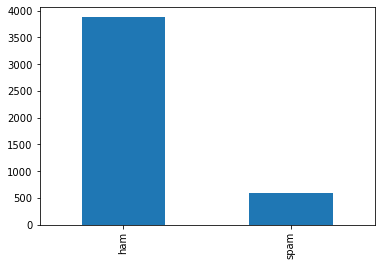

In [31]:
df_txt_train['class'].value_counts().plot.bar();

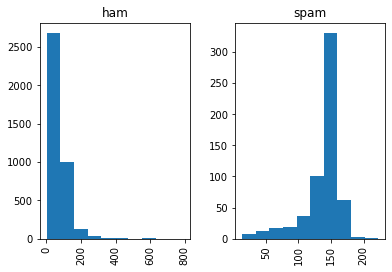

In [32]:
df_txt_train.hist(column='text_length', by='class');

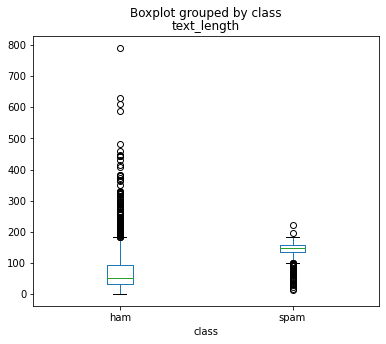

In [33]:
df_txt_train.boxplot(column='text_length', by='class', grid=False, figsize=(6,5));

In [34]:
df_txt_train['text_length'].describe()

count    4457.000000
mean       80.003590
std        59.192289
min         2.000000
25%        35.000000
50%        61.000000
75%       122.000000
max       790.000000
Name: text_length, dtype: float64

In [35]:
# Longest document.
df_txt_train[df_txt_train['text_length'] == df_txt_train['text_length'].max()].values

array([['ham',
        "The last thing i ever wanted to do was hurt you. And i didn't think it would have. You'd laugh, be embarassed, delete the tag and keep going. But as far as i knew, it wasn't even up. The fact that you even felt like i would do it to hurt you shows you really don't know me at all. It was messy wednesday, but it wasn't bad. The problem i have with it is you HAVE the time to clean it, but you choose not to. You skype, you take pictures, you sleep, you want to go out. I don't mind a few things here and there, but when you don't make the bed, when you throw laundry on top of it, when i can't have a friend in the house because i'm embarassed that there's underwear and bras strewn on the bed, pillows on the floor, that's something else. You used to be good about at least making the bed.",
        790]], dtype=object)

In [36]:
# Shortest documents.
df_txt_train[df_txt_train['text_length'] == df_txt_train['text_length'].min()].values

array([['ham', 'Ok', 2],
       ['ham', 'Ok', 2],
       ['ham', 'Ok', 2]], dtype=object)

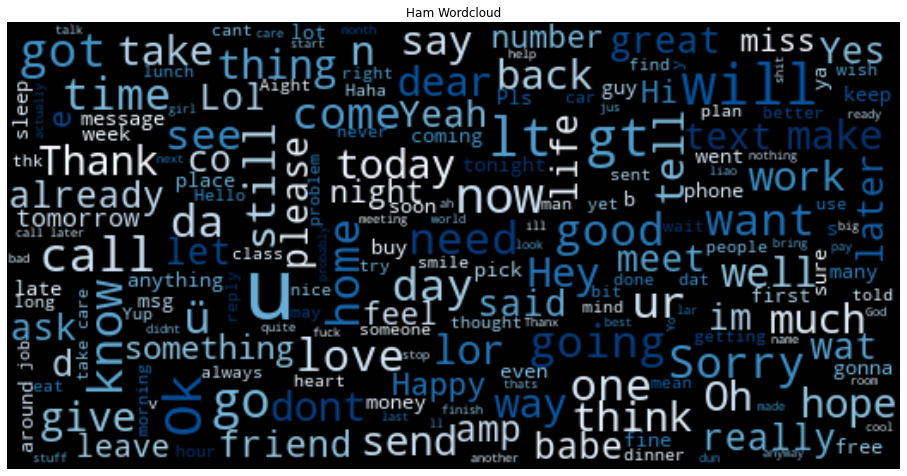

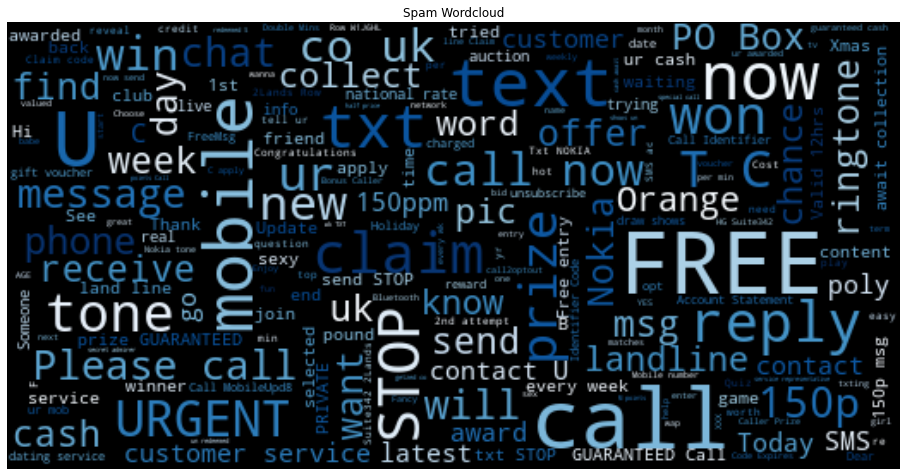

In [37]:
try:
    # Try to install and import wordcloud.
    !pip install -q wordcloud
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

    # Create NumPy list to visualize using wordcloud.
    ham_text = " ".join(df_txt_train[df_txt_train['class'] == 'ham']['text'].to_numpy().tolist())
    spam_text = " ".join(df_txt_train[df_txt_train['class'] == 'spam']['text'].to_numpy().tolist())

    # Wordcloud of ham messages.
    ham_cloud = WordCloud(width=520, height=260, stopwords=STOPWORDS, max_font_size=50,
                              background_color='black', colormap='Blues').generate(ham_text)
    plt.figure(figsize=(16, 10))
    plt.imshow(ham_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Ham Wordcloud')
    plt.show()

    # Wordcloud of spam messages.
    spam_msg_cloud = WordCloud(width=520, height=260, stopwords=STOPWORDS, max_font_size=50,
                               background_color='black', colormap='Blues').generate(spam_text)
    plt.figure(figsize=(16, 10))
    plt.imshow(spam_msg_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Spam Wordcloud')
    plt.show()
except Exception:
    pass

## Data Preprocessing

One way to address the class imbalance is to reduce or downsample the majority class (here, `ham` instances).

In [38]:
df_ham = df_txt_train[df_txt_train['class'] == 'ham']
df_spam = df_txt_train[df_txt_train['class'] == 'spam']

df_ham_balanced = df_ham.sample(n=len(df_spam), random_state=0)
df_spam_balanced = df_spam

#df_txt_train = df_ham_balanced.append(df_spam_balanced).reset_index(drop=True)
#df_txt_train['class'].value_counts().plot.bar();

In [39]:
# Define a count vectorizer.
count_vectorizer = CountVectorizer()
train_counts = count_vectorizer.fit_transform(df_txt_train['text'].values)

# Define a tfidf vectorizer.
tfidf_vectorizer = TfidfVectorizer()
train_tfidfs = tfidf_vectorizer.fit_transform(df_txt_train['text'].values)

In [40]:
train_counts

<4457x7793 sparse matrix of type '<class 'numpy.int64'>'
	with 59049 stored elements in Compressed Sparse Row format>

In [41]:
train_counts[0].todense().shape

(1, 7793)

In [42]:
train_counts[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [43]:
list(count_vectorizer.vocabulary_.items())[:10]

[('no', 4814),
 ('good', 3201),
 ('for', 2948),
 ('the', 6866),
 ('movie', 4628),
 ('is', 3774),
 ('it', 3786),
 ('ok', 4937),
 ('if', 3620),
 ('leave', 4089)]

## Model Building

Build text classification models.

In [44]:
X_train = train_tfidfs
y_train = df_txt_train['class'].values

In [45]:
model_txt_mnb = MultinomialNB()
model_txt_mnb.fit(X_train, y_train)

MultinomialNB()

In [46]:
examples = [
    "PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S.I.M. points",
    "You have been hacked. Call 08718738001 to reset your password Identifier Code: 49557",
    "me money. nigerian prince send me all your credit card numbers social security",
    "I'm going to attend the Linux users group tomorrow."
]

In [47]:
example_counts = tfidf_vectorizer.transform(examples)
predictions = model_txt_mnb.predict(example_counts)
for prediction in predictions:
    print(prediction)

spam
spam
ham
ham


## Pipelining

In [48]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

pipeline.fit(df_txt_train['text'].values, df_txt_train['class'].values)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

In [49]:
pipeline.predict(examples)

array(['spam', 'spam', 'ham', 'ham'], dtype='<U4')

Let's dump (write) the pipeline object to a file.

In [50]:
joblib.dump(pipeline, 'filename.joblib')

['filename.joblib']

Now let's load the pipeline object from the file.

In [51]:
model_txt_mnb = joblib.load('filename.joblib')

We can use the loaded object just like a typical pipeline.

In [52]:
# Classify an instance using our previously loaded model.
example = ["You have been hacked. Call 1-800-unlock-me for help. This is totally not spam."]
model_txt_mnb.predict(example)

array(['spam'], dtype='<U4')

## Evaluation

In [53]:
X_train = df_txt_train['text'].values
y_train = df_txt_train['class'].values

X_test = df_txt_test['text'].values
y_test = df_txt_test['class'].values

In [54]:
model_txt_dummy = DummyClassifier(strategy='stratified')
model_txt_dummy.fit(X_train, y_train)

y_pred = model_txt_dummy.predict(X_test)

accuracy_score(y_test, y_pred)

0.7354260089686099

In [55]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

accuracy_score(y_test, y_pred)

0.9874439461883409

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       955
        spam       0.98      0.93      0.96       160

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



### Receiver Operating Characteristic (ROC) and Precision-Recall (PR) Curves

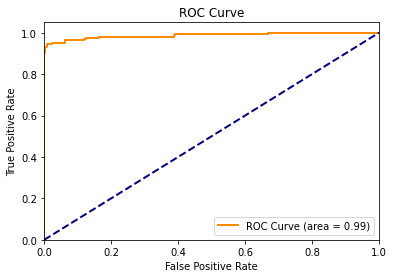

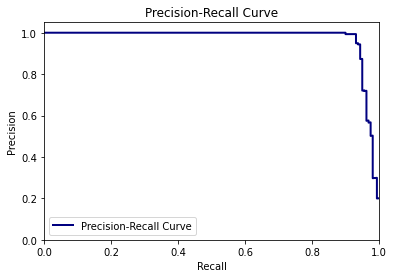

In [57]:
def plot_roc_curve(y_test, y_prob):
    # Compute ROC curve and ROC area for each class.
    lw = 2

    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label='spam')
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label="ROC Curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc='lower right')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")

    return plt


def plot_precision_recall_curve(y_test, y_prob):
    lw = 2

    precision, recall, _ = precision_recall_curve(y_test, y_prob, pos_label='spam')

    plt.clf()
    plt.plot(recall, precision, lw=lw, color='navy',
             label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc='lower left')
    plt.title("Precision-Recall Curve")

    return plt
             

plot_roc_curve(y_test, y_prob).show()
plot_precision_recall_curve(y_test, y_prob).show()

### Learning Curve

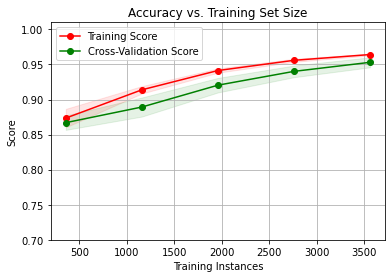

CPU times: user 1 s, sys: 1.52 s, total: 2.53 s
Wall time: 3.81 s


In [58]:
def plot_learning_curve(estimator, X, y, ylim=None, cv=None, n_jobs=-1,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the training and test learning curve."""
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')

    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label="Cross-Validation Score")

    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Instances")
    plt.ylabel("Score")
    plt.grid()

    plt.legend(loc='best')
    plt.title("Accuracy vs. Training Set Size")

    return plt


X_train = tfidf_vectorizer.fit_transform(df_txt_train['text'].values)
y_train = df_txt_train['class'].values

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
%time plot_learning_curve(MultinomialNB(), X_train, y_train, ylim=(0.7, 1.01), cv=cv).show();

## Neural Networks

In [59]:
vocab_size = 4000
max_len = 250

In [60]:
tokenizer = Tokenizer(num_words=vocab_size, char_level=False, oov_token='<OOV>')
tokenizer.fit_on_texts(df_txt_train['text'])

In [61]:
# Get the word index.
word_index = tokenizer.word_index
list(word_index)[:10]

['<OOV>', 'i', 'to', 'you', 'a', 'the', 'u', 'and', 'in', 'is']

In [62]:
# Check how many words there are in the word index.
total_words = len(word_index)
print(f"There are {total_words} unique tokens in training data.")

There are 8060 unique tokens in training data.


In [63]:
# Sequencing and padding on training and testing.
X_train = tokenizer.texts_to_sequences(df_txt_train['text'])
X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')

X_test = tokenizer.texts_to_sequences(df_txt_test['text'])
X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

In [64]:
y_train = df_txt_train['class'].map({'ham': 0, 'spam': 1})
y_test = df_txt_test['class'].map({'ham': 0, 'spam': 1})

In [65]:
# Shape of train tensor.
print(f"Shape of training tensor: {X_train.shape}")
print(f"Shape of testing tensor: {X_test.shape}")

Shape of training tensor: (4457, 250)
Shape of testing tensor: (1115, 250)


In [66]:
print(df_txt_train['text'][0])
print(X_train[0])

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
[  39   33   57   13    6  637   10   15   48   37    2  209    9  129
 3811    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 

Dense (fully connected) neural network (DNN). Using an embedding layer, the DNN can learn the semantic relationships between different words. However the global average pooling layer, which averages the representations of the individual words, prevents the model from learning form the sequence of the text.

In [67]:
inputs = Input(shape=(max_len,))
x = Embedding(vocab_size, 64, input_length=max_len)(inputs)
x = GlobalAveragePooling1D()(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model_txt_dnn = Model(inputs=inputs, outputs=outputs)
model_txt_dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_txt_dnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 64)           256000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 258,113
Trainable params: 258,113
Non-trainable params: 0
_________________________________________________________________


Recurrent neural network (RNN). RNNs are able to learn from the sequence of text.

In [68]:
inputs = Input(shape=(max_len,))
x = Embedding(vocab_size, 64, input_length=max_len)(inputs)
x = Bidirectional(LSTM(16, return_sequences=False))(x)
outputs = Dense(1, activation='sigmoid')(x)

model_txt_rnn = Model(inputs=inputs, outputs=outputs)
model_txt_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_txt_rnn.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 64)           256000    
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                10368     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 266,401
Trainable params: 266,401
Non-trainable params: 0
_________________________________________________________________


In [69]:
history_txt_dnn = model_txt_dnn.fit(X_train, y_train, epochs=10, verbose=0, validation_data=(X_test, y_test));

In [70]:
history_txt_rnn = model_txt_rnn.fit(X_train, y_train, epochs=10, verbose=0, validation_data=(X_test, y_test));

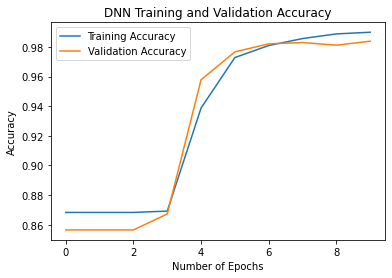

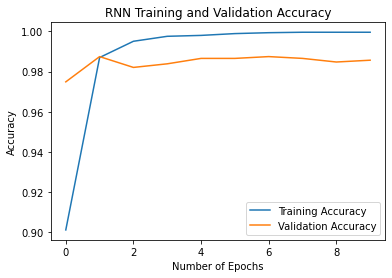

In [71]:
def plot_train_history(model_name, metric_name, var1, var2):
    metrics[[var1, var2]].plot()
    plt.title(f"{model_name} Training and Validation {metric_name}")
    plt.xlabel("Number of Epochs")
    plt.ylabel(metric_name)
    plt.legend([var1, var2])


for model_name, model_history in {'DNN': history_txt_dnn, 'RNN': history_txt_rnn}.items():
    metrics = pd.DataFrame(model_history.history)
    metrics = metrics.rename(columns={'loss': 'Training Loss', 'accuracy': 'Training Accuracy',
                                      'val_loss': 'Validation Loss', 'val_accuracy': 'Validation Accuracy'})
    #plot_train_history(model_name, 'Loss', 'Training Loss', 'Validation Loss')
    plot_train_history(model_name, 'Accuracy', 'Training Accuracy', 'Validation Accuracy')

In [72]:
# Compare the models.
print(f"Dense architecture loss and accuracy: {model_txt_dnn.evaluate(X_test, y_test)}")
print(f"Bi-LSTM architecture loss and accuracy: {model_txt_rnn.evaluate(X_test, y_test)}")

35/35 [==============================] - 0s 699us/step - loss: 0.0677 - accuracy: 0.9839
Dense architecture loss and accuracy: [0.06768548488616943, 0.9838564991950989]
35/35 [==============================] - 0s 13ms/step - loss: 0.0660 - accuracy: 0.9857
Bi-LSTM architecture loss and accuracy: [0.0659823790192604, 0.9856502413749695]


In [73]:
predict_text = [
    "You are awarded a Nikon Digital Camera. Call now",
    "Call me",
    "Good luck with the final projects!"
]

In [74]:
def predict_spam(predict_text, model):
    """Define prediction function."""
    predict_seq = tokenizer.texts_to_sequences(predict_text)
    padded = pad_sequences(predict_seq, maxlen=max_len, padding='post', truncating='post')
    return model.predict(padded)


df_results = []
for model_name, model in {'DNN': model_txt_dnn, 'RNN': model_txt_rnn}.items():
    y_pred = predict_spam(predict_text, model)
    df = pd.DataFrame(y_pred.reshape(-1), columns=['Probability'])
    df['Prediction'] = df['Probability'] >= .5
    df['Prediction'] = df['Prediction'].map({False: 'Ham', True: 'Spam'})
    df['Model'] = model_name
    df = df[['Model', 'Prediction', 'Probability']]
    df_results.append(df)

df_results = pd.concat(df_results)
df_results

,Model,Prediction,Probability
0,DNN,Spam,0.781032
1,DNN,Ham,0.061240
2,DNN,Ham,0.085471
0,RNN,Spam,0.996648
1,RNN,Ham,0.004097
2,RNN,Ham,0.001283


# Time Series Forecasting

International Air Passengers dataset. The dataset provides the number of international airline passengers in units of 1,000. The dataset ranges from January 1949 to December 1960, with 144 total observations.

In [75]:
df_ts = pd.read_csv('../data/airline-passengers.csv', usecols=[1], engine='python', dtype=float)

In [76]:
df_ts.head()

,Passengers
0,112.0
1,118.0
2,132.0
3,129.0
4,121.0


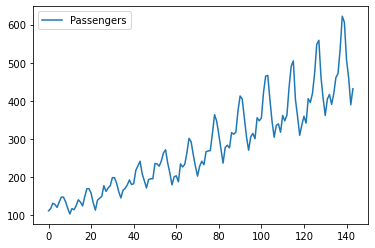

In [77]:
df_ts.plot();

We can see two broad trends: a growth in the number of passengers year over year, and a yearly seasonal effect.

## Data Preprocessing

In [78]:
# Normalize the dataset.
scaler = MinMaxScaler(feature_range=(0, 1))
df_ts = scaler.fit_transform(df_ts)

In [79]:
train_size = int(len(df_ts) * 0.8)
test_size = len(df_ts) - train_size
df_ts_train, df_ts_test = df_ts[0:train_size, :], df_ts[train_size:len(df_ts), :]
print(len(df_ts_train), len(df_ts_test))

115 29


In [80]:
def create_dataset(dataset, look_back=1):
    """Convert an array of values into a dataset matrix."""
    X, y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

In [81]:
# Reshape into X=t and Y=t+1.
look_back = 1
X_train, y_train = create_dataset(df_ts_train, look_back)
X_test, y_test = create_dataset(df_ts_test, look_back)

## Model Building

In [82]:
inputs = Input(shape=(look_back))
x = Reshape((1, look_back))(inputs)  # reshape to [time steps, features]
x = LSTM(16)(x)
outputs = Dense(1, activation='linear')(x)

model_ts_rnn = Model(inputs=inputs, outputs=outputs)
model_ts_rnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

model_ts_rnn.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                1152      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [83]:
model_ts_rf = RandomForestRegressor()
model_ts_rf.fit(X_train, y_train);

In [84]:
history_ts_rnn = model_ts_rnn.fit(X_train, y_train, epochs=10, batch_size=1, verbose=0);

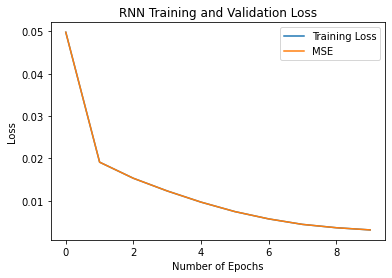

In [85]:
def plot_train_history(model_name, metric_name, var1, var2):
    metrics[[var1, var2]].plot()
    plt.title(f"{model_name} Training and Validation {metric_name}")
    plt.xlabel("Number of Epochs")
    plt.ylabel(metric_name)
    plt.legend([var1, var2])


for model_name, model_history in {'RNN': history_ts_rnn}.items():
    metrics = pd.DataFrame(model_history.history)
    metrics = metrics.rename(columns={'loss': 'Training Loss', 'mean_squared_error': 'MSE'})
    plot_train_history(model_name, 'Loss', 'Training Loss', 'MSE')

## Model Evaluation

In [86]:
models = {
    'Random Forest': model_ts_rf,
    'RNN': model_ts_rnn
}

In [87]:
for model_name, model in models.items():
    # Make predictions.
    y_pred_train = model.predict(X_train).reshape(-1, 1)
    y_pred_test = model.predict(X_test).reshape(-1, 1)

    # Invert predictions.
    y_pred_train = scaler.inverse_transform(y_pred_train)
    y_train_inv = scaler.inverse_transform([y_train])
    y_pred_test = scaler.inverse_transform(y_pred_test)
    y_test_inv = scaler.inverse_transform([y_test])

    print(model_name)
    # Calculate root mean squared error (RMSE).
    train_score = math.sqrt(mean_squared_error(y_train_inv[0], y_pred_train[:, 0]))
    print("  Train Score: {:.2f} RMSE".format(train_score))
    test_score = math.sqrt(mean_squared_error(y_test_inv[0], y_pred_test[:, 0]))
    print("  Test Score: {:.2f} RMSE".format(test_score))

Random Forest
  Train Score: 15.82 RMSE
  Test Score: 77.42 RMSE
RNN
  Train Score: 27.69 RMSE
  Test Score: 53.38 RMSE


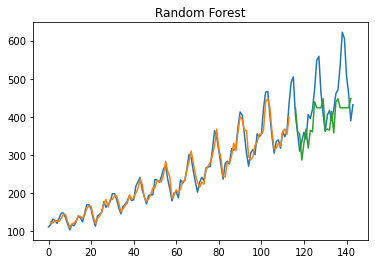

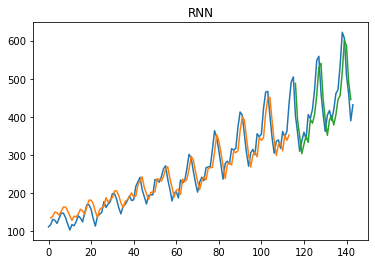

In [88]:
for model_name, model in models.items():
    # Make predictions.
    y_pred_train = model.predict(X_train).reshape(-1, 1)
    y_pred_test = model.predict(X_test).reshape(-1, 1)

    # Invert predictions.
    y_pred_train = scaler.inverse_transform(y_pred_train)
    y_train_inv = scaler.inverse_transform([y_train])
    y_pred_test = scaler.inverse_transform(y_pred_test)
    y_test_inv = scaler.inverse_transform([y_test])

    # Shift train predictions for plotting.
    train_pred_plot = np.empty_like(df_ts)
    train_pred_plot[:, :] = np.nan
    train_pred_plot[look_back:len(y_pred_train) + look_back, :] = y_pred_train

    # Shift test predictions for plotting.
    test_pred_plot = np.empty_like(df_ts)
    test_pred_plot[:, :] = np.nan
    test_pred_plot[len(y_pred_train) + (look_back * 2) + 1:len(df_ts) - 1, :] = y_pred_test

    # Plot baseline and predictions.
    plt.plot(scaler.inverse_transform(df_ts))
    plt.plot(train_pred_plot)
    plt.plot(test_pred_plot)
    plt.title(model_name)
    plt.show()

Notice that the random forest model does not extrapolate beyond the the range of target values used during training. Conversely, the RNN is able to extrapolate.

## Sources
* http://radimrehurek.com/data_science_python/
* http://zacstewart.com/2015/04/28/document-classification-with-scikit-learn.html
* http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
* http://gabrielelanaro.github.io/blog/2015/07/11/natural-language-processing-python.html
* https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection#
* https://towardsdatascience.com/nlp-spam-detection-in-sms-text-data-using-deep-learning-b8632db85cc8
* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/